**Notebook and GPU preparation with Google Colab**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec  2 02:57:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    67W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/Retinal_Disease/retinal_disease.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content')

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


**Packages and data preprocessing**

In [ ]:
#Importation of packages and datasets
import os 
from tqdm import tqdm
from glob import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf

from warnings import filterwarnings
filterwarnings('ignore')


print(os.getcwd())
path_cwd = os.getcwd()

X_train = pd.read_csv('/content/drive/MyDrive/CS 682/Project/OriginalDataset/Training_Set/RFMiD_Training_Labels.csv')
X_val = pd.read_csv('/content/drive/MyDrive/CS 682/Project/OriginalDataset/Evaluation_Set/RFMiD_Validation_Labels.csv')
X_test = pd.read_csv('/content/drive/MyDrive/CS 682/Project/OriginalDataset/Test_Set/RFMiD_Testing_Labels.csv')

/content


In [ ]:
X_test

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train['ID']

0          1
1          2
2          3
3          4
4          5
        ... 
1915    1916
1916    1917
1917    1918
1918    1919
1919    1920
Name: ID, Length: 1920, dtype: int64

In [ ]:
X_train.describe()
#No missing value

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.0,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,960.500000,0.791146,0.195833,0.052083,0.165104,0.071875,0.052604,0.038021,0.096875,0.007292,0.024479,0.007812,0.019271,0.146875,0.014583,0.003125,0.008333,0.033854,0.030208,0.002604,0.008854,0.005729,0.007292,0.022396,0.016667,0.007812,0.011458,0.005729,0.003125,0.001563,0.000521,0.0,0.001042,0.001563,0.0,0.001042,0.001563,0.002083,0.002604,0.001563,0.000521,0.000521,0.000521,0.001042,0.000521,0.000521,0.000521
std,554.400577,0.406596,0.396944,0.222253,0.371371,0.258348,0.223300,0.191296,0.295865,0.085102,0.154572,0.088065,0.137511,0.354073,0.119909,0.055829,0.090930,0.180901,0.171205,0.050978,0.093703,0.075494,0.085102,0.148006,0.128052,0.088065,0.106456,0.075494,0.055829,0.039508,0.022822,0.0,0.032266,0.039508,0.0,0.032266,0.039508,0.045608,0.050978,0.039508,0.022822,0.022822,0.022822,0.032266,0.022822,0.022822,0.022822
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,480.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,960.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1440.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1920.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#reconstituion link image + drop ID feature
X_train['filename'] = X_train.apply(lambda x : "/content/drive/MyDrive/CS 682/Project/Resized/training/" +str(x['ID']) + ".png", axis=1)
X_val['filename'] = X_val.apply(lambda x : "/content/drive/MyDrive/CS 682/Project/Resized/Validation/" +str(x['ID']) + ".png", axis=1)
X_test['filename'] = X_test.apply(lambda x : "/content/drive/MyDrive/CS 682/Project/Resized/test/" +str(x['ID']) + ".png", axis=1)

X_train = X_train.drop('ID', axis=1)
X_val = X_val.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [ ]:
print(X_train.head(1))
print(X_train.shape)
#46 class + risk evaluation (47 features)

   Disease_Risk  DR  ...  CL                                           filename
0             1   1  ...   0  /content/drive/MyDrive/CS 682/Project/Resized/...

[1 rows x 47 columns]
(1920, 47)


In [ ]:
#datasets
X_train_img = X_train['filename']
X_val_img = X_val['filename']
y_train = X_train.drop(['filename'], axis=1)
y_val = X_val.drop(['filename'], axis=1)

print('shape of X_train:', X_train_img.shape)
print('shape of Validation:', X_val_img.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_val:', y_val.shape)

shape of X_train: (1920,)
shape of Validation: (640,)
shape of y_train: (1920, 46)
shape of y_val: (640, 46)


In [ ]:
#Plot some random images
import cv2
import random
def plotImages():
    i=1
    plt.figure(figsize=(15,10))
    for r in random.sample(glob('/content/drive/MyDrive/CS 682/Project/Resized/training/**'), 15):
      plt.subplot(3,5,i)
      img = cv2.imread(r)
      img = tf.reverse(img, axis=[-1])
      img =  tf.image.adjust_contrast(img, 1.5)
      plt.imshow(img)
      i+=1
      plt.axis('off')

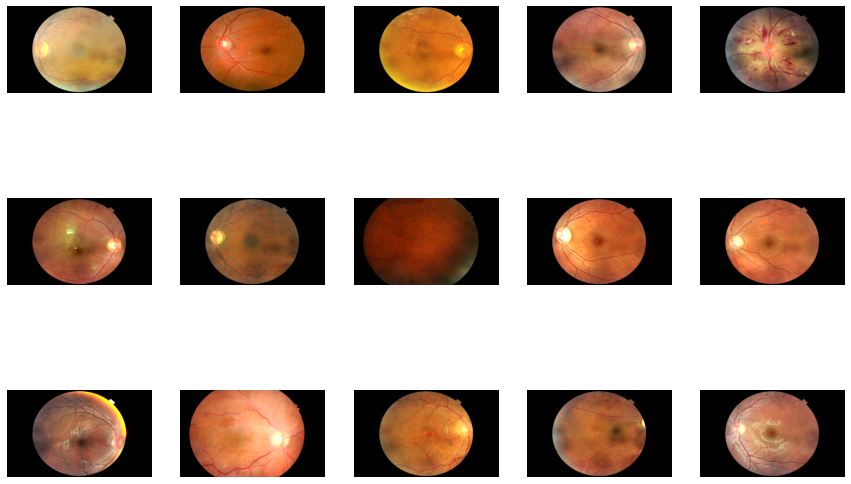

In [ ]:
plotImages() #Seems we have to convert to RGB format

## Preprocessing images

In [ ]:
IMG_SHAPE = (150, 250)
BATCH_SIZE = 64

In [ ]:
@tf.function

#Fonction pour prprocessing des images
def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, (150, 250), method='nearest')
    img = (img / 255)
    
    return img

#Preprocessing du jeu d'entrainement
def preprocessing_data(img):
   
    #Lecture et décodage des images:
    img = tf.io.read_file(img)
    img = tf.io.decode_png(img, channels=3)

    #adjust contrast
    img =  tf.image.adjust_contrast(img, 1.35)

    #Resize
    img = scale_down(img)

    return img


In [ ]:
# X_test_path = X_test['filename']
# y_test = X_test.drop(['filename'], axis=1)
# y_test = np.array(y_test).astype('float32')

# print('shape of X_test:', X_test.shape)
# print('shape of y_test:', y_test.shape)


# new_X_train_img  = []
# for filepath in tqdm(X_train_img):

#   #Read and decode
#   img = tf.io.read_file(filepath)
#   img = tf.io.decode_png(img, channels=3)

#   #adjust contrast
#   img =  tf.image.adjust_contrast(img, 1.5)

#   #Resize
#   img = scale_down(img)
#   new_X_train_img.append([img])

In [ ]:
#Datasets preprocessing
AUTO = tf.data.experimental.AUTOTUNE

y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_img, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_img, y_val))

dataset_train=(dataset_train
               .shuffle(1000)
               .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(AUTO)
               )


dataset_val=(dataset_val
             .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
             .batch(BATCH_SIZE, drop_remainder=True)
             .prefetch(AUTO)
             )


print(dataset_train)
print(dataset_val)

<PrefetchDataset shapes: ((64, 150, 250, 3), (64, 46)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((64, 150, 250, 3), (64, 46)), types: (tf.float32, tf.float32)>


In [ ]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


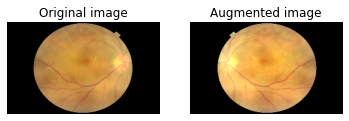

In [ ]:
image, label = next(iter(dataset_train))
image, label = image.numpy()[0], label.numpy()[0]


flipped = tf.image.flip_left_right(image)
flipped =  tf.image.adjust_contrast(flipped, 1.35)
visualize(image, flipped)

```
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator


class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=64):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch


    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(X_train_path, y_train, train_generator, batch_size=64)
#balanced_gen_val = BalancedDataGenerator(X_val, y_val, train_generator, batch_size=64)
steps_per_epoch = balanced_gen.steps_per_epoch

```



In [ ]:
#API keras preparation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D, Dense, Flatten, GlobalAvgPool2D
from keras import backend as K
from tensorflow.keras.applications import VGG16
vgg16 = VGG16()

#for layer in xception.layers:
#    print(layer.name, layer)

## Classification model

In [ ]:
def UNet(inputs):
    # First convolution block
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    d1_con = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)
    
    # Second convolution block
    d2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2_con = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)
    
    # Third convolution block
    d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)
    
    # Fourth convolution block
    d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)
    
    # Bottleneck layer
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)
    
    # First upsampling block
    u1 = tf.keras.layers.Conv2DTranspose(512, 3, strides =(2,2),padding='same')(b)
    u1 = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (1, 0)))(u1)
    u1 = tf.keras.layers.Concatenate(axis=3)([u1, d4_con])
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    
    # Second upsampling block
    u2 = tf.keras.layers.Conv2DTranspose(256, 3, strides =(2,2),padding='same')(u1)
    u2 = tf.keras.layers.ZeroPadding2D(padding=((1, 0), (0, 0)))(u2)
    u2 = tf.keras.layers.Concatenate(axis=3)([u2, d3_con])
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    
    # Third upsampling block
    u3 = tf.keras.layers.Conv2DTranspose(128, 3, strides =(2,2),padding='same')(u2)
    u3 = tf.keras.layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(u3)
    u3 = tf.keras.layers.Concatenate(axis=3)([u3, d2_con])
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    
    # Fourth upsampling block
    u4 = tf.keras.layers.Conv2DTranspose(64, 3, strides =(2,2),padding='same')(u3)
    u4 = tf.keras.layers.Concatenate(axis=3)([u4, d1_con])
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    
    # Flatten and output
    l = tf.keras.layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_normal')(u4)
    l = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(l)
    l = tf.keras.layers.Conv2D(8, 3, activation='relu', kernel_initializer='he_normal')(l)
    l = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(l)
    flat = tf.keras.layers.Flatten()(l)
    out = tf.keras.layers.Dense(units=46, activation='sigmoid')(flat)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [ ]:
shape = (150, 250,3)

# def Layers(inputs, trainable=False):
#     global vgg16_model
#     vgg16_model = VGG16(weights='imagenet',
#                         include_top=False,
#                         input_tensor=inputs)
    
#     if trainable == True:
#         for layer in vgg16_model.layers:
#             layer.trainable = True
            
#     else:
#         vgg16_model.trainable = False
            
#     return vgg16_model.output
    
        
def Build_UNet(trainable=False):
    
    inputs = Input(shape=shape)
    return(UNet(inputs))
    
model = Build_UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 250, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 150, 250, 64  36928       ['conv2d[0][0]']                 
                                )                                                             



*   use a LR function to adapt Gradient
*   Class imbalanced, we create a loss fonction to adjust weight 



In [ ]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):

        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]


            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)

callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=2)

In [ ]:
#Re-Weighting classes binary crossentropy

def dyn_weighted_bincrossentropy(true, pred):

    # get the total number of inputs
    num_pred = K.sum(K.cast(pred < 0.5, true.dtype)) + K.sum(true)
    # get weight of values in 'pos' category
    zero_weight =  K.sum(true)/ num_pred +  K.epsilon() 
    # get weight of values in 'false' category
    one_weight = K.sum(K.cast(pred < 0.5, true.dtype)) / num_pred +  K.epsilon()
    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return K.mean(weighted_bin_crossentropy)


def weighted_bincrossentropy(true, pred, weight_zero = 0.25, weight_one = 1):

    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return K.mean(weighted_bin_crossentropy)

In [ ]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=5000, from_logits=True, name='pr_metric') # The higher the threshold value, the more accurate it is calculated.
roc_metric = AUC(curve='ROC', num_thresholds=5000, from_logits=True, name='roc_metric') 


In [ ]:
from tensorflow.keras.metrics import Recall, Precision
#from tensorflow_addons.metrics import F1Score

#f1_sc = F1Score()
recall = Recall()
prec = Precision()

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import HammingLoss
hamm = HammingLoss(threshold=0.5, mode='multilabel')

In [ ]:
model.compile(loss=dyn_weighted_bincrossentropy,
              optimizer =tf.keras.optimizers.Adam(),
              metrics= [roc_metric, pr_metric,'acc',recall,prec,hamm,f1_m])

#weighted_binary_crossentropy

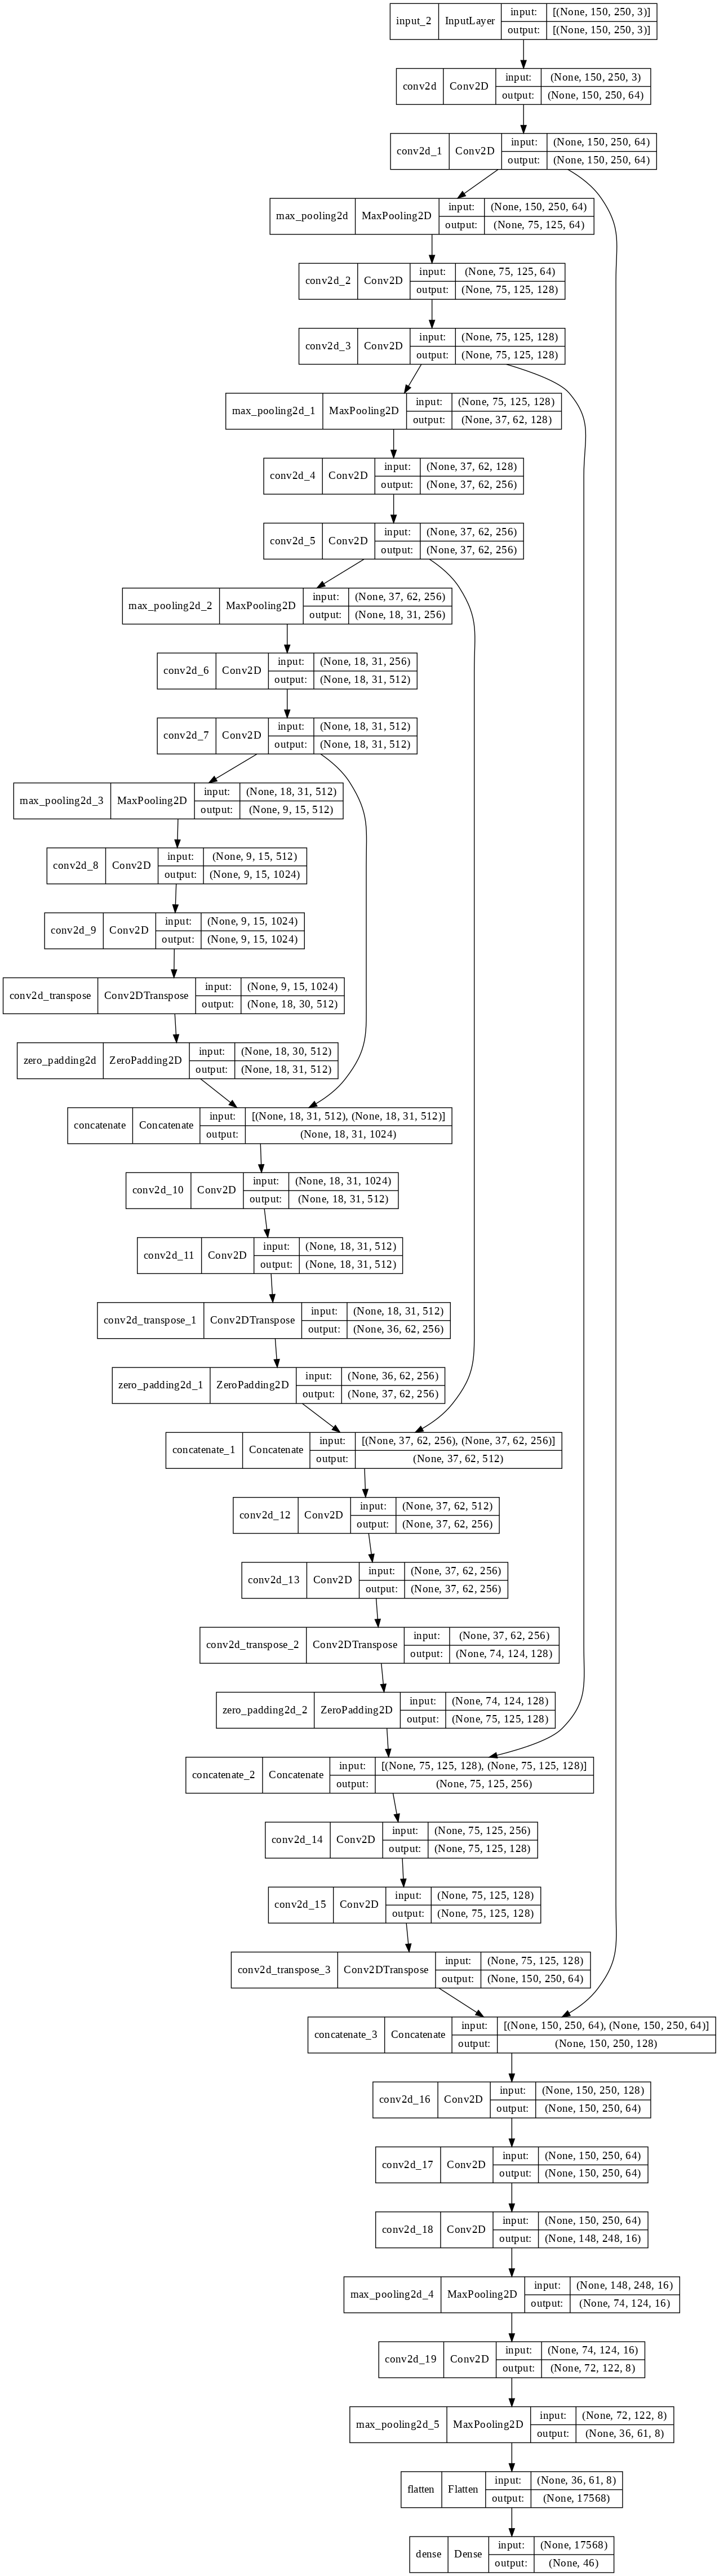

In [ ]:
tf.keras.utils.plot_model(model, 'retinal_output_model.png', show_shapes=True, dpi=100)

In [ ]:
regularizer = tf.keras.regularizers.l2(.001)
for layer in model.layers:
    if layer.trainable == True:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

In [ ]:
history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    epochs=5, 
                    verbose=1, 
                   callbacks=callback_lr)

Setting learning rate to 0.001
Epoch 1/5
30/30 [==============================] - 262s 7s/step - loss: 0.0397 - roc_metric: 0.9025 - pr_metric: 0.4210 - acc: 0.9667 - recall: 0.8099 - precision: 0.1765 - hamming_loss: 0.1612 - f1_m: 0.3107 - val_loss: 0.0295 - val_roc_metric: 0.9178 - val_pr_metric: 0.5160 - val_acc: 1.0000 - val_recall: 0.7982 - val_precision: 0.2136 - val_hamming_loss: 0.1279 - val_f1_m: 0.3336
Setting learning rate to 0.001
Epoch 2/5
30/30 [==============================] - 128s 4s/step - loss: 0.0286 - roc_metric: 0.9266 - pr_metric: 0.5505 - acc: 1.0000 - recall: 0.8428 - precision: 0.1946 - hamming_loss: 0.1481 - f1_m: 0.3179 - val_loss: 0.0303 - val_roc_metric: 0.9149 - val_pr_metric: 0.4986 - val_acc: 1.0000 - val_recall: 0.8173 - val_precision: 0.1914 - val_hamming_loss: 0.1481 - val_f1_m: 0.3073
Setting learning rate to 0.001
Epoch 3/5
30/30 [==============================] - 128s 4s/step - loss: 0.0276 - roc_metric: 0.9320 - pr_metric: 0.5734 - acc: 1.0000 -

In [ ]:
from keras.models import model_from_json

model_archtecture = model.to_json()

with open('retinal_model.json', 'w') as json_file:
    json_file.write(model_archtecture)

model.save('./retinal_model')
model.save_weights('./retinal_model.h5')

INFO:tensorflow:Assets written to: ./retinal_model/assets


In [ ]:
 !zip -r /content/retinal_model.zip /content/retinal_model

  adding: content/retinal_model/ (stored 0%)
  adding: content/retinal_model/assets/ (stored 0%)
  adding: content/retinal_model/variables/ (stored 0%)
  adding: content/retinal_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/retinal_model/variables/variables.index (deflated 77%)
  adding: content/retinal_model/keras_metadata.pb (deflated 95%)
  adding: content/retinal_model/saved_model.pb (deflated 90%)


## Predictions and ROC/PR curves on X_test

In [ ]:
#preparation and preprocesing
X_test_path = X_test['filename']
y_test = X_test.drop(['filename'], axis=1)
y_test = np.array(y_test).astype('float32')

print('shape of X_test:', X_test.shape)
print('shape of y_test:', y_test.shape)

X_test_img  = []
for filepath in tqdm(X_test_path):

  #Read and decode
  img = tf.io.read_file(filepath)
  img = tf.io.decode_png(img, channels=3)

  #adjust contrast
  img =  tf.image.adjust_contrast(img, 1.5)

  #Resize
  img = scale_down(img)
  X_test_img.append([img])


shape of X_test: (640, 47)
shape of y_test: (640, 46)


100%|██████████| 640/640 [02:10<00:00,  4.90it/s]


In [ ]:
#transform to array numpy
X_test_img = np.array(X_test_img)
X_test_img = X_test_img[:,0,:,:]
X_test_img.shape

(640, 150, 250, 3)

In [ ]:
model.evaluate( x = X_test_img, y = y_test, batch_size=32, verbose=1)

20/20 [==============================] - 33s 612ms/step - loss: 0.0275 - roc_metric: 0.9312 - pr_metric: 0.6231 - acc: 1.0000 - recall: 0.8511 - precision: 0.1997 - hamming_loss: 0.1421 - f1_m: 0.3162


[0.02750052511692047,
 0.9311893582344055,
 0.62310391664505,
 1.0,
 0.8510638475418091,
 0.19972039759159088,
 0.14205162227153778,
 0.3161759376525879]

In [ ]:
y_pred = model.predict(X_test_img)

In [ ]:
from sklearn.metrics import roc_auc_score

auc_scores = []
for i in range(46):
  try:
    auc = roc_auc_score(y_test[:,i], y_pred[:,i])
    auc_scores.append(auc)
  except:
    pass


def Average(lst):
    return sum(lst) / len(lst)
  
avg_auc = Average(auc_scores)
  
# Printing average of the list
print("Average auc score available classes =", round(avg_auc, 2),'%')

Average auc score available classes = 0.54 %


In [ ]:
mask = y_pred > 0.9
mask = mask*1

In [ ]:
print(mask == y_test)
cnt = 0


[[ True False  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 ...
 [ True False  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True False False ...  True  True  True]]


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, mask))

0.075


In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

hamming_score(y_test, mask)

0.3860677083333333

dict_keys(['loss', 'roc_metric', 'pr_metric', 'acc', 'recall', 'precision', 'hamming_loss', 'f1_m', 'val_loss', 'val_roc_metric', 'val_pr_metric', 'val_acc', 'val_recall', 'val_precision', 'val_hamming_loss', 'val_f1_m'])


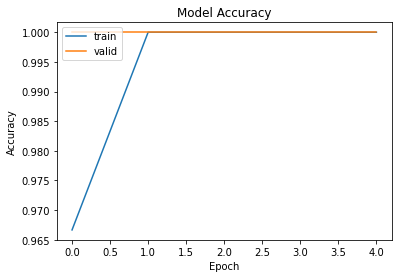

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/Accuracy.png')
plt.show()

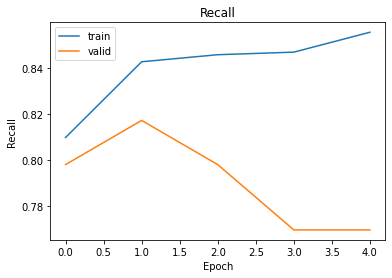

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/Recall.png')
plt.show()


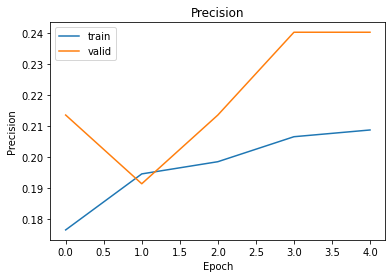

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/Precision.png')
plt.show()


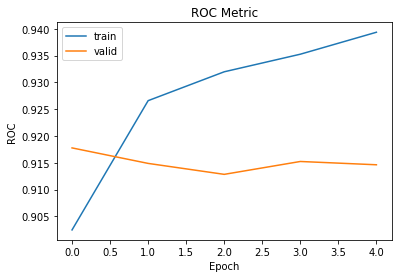

In [ ]:
plt.plot(history.history['roc_metric'])
plt.plot(history.history['val_roc_metric'])
plt.title('ROC Metric')
plt.ylabel('ROC')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/ROCMetric.png')
plt.show()


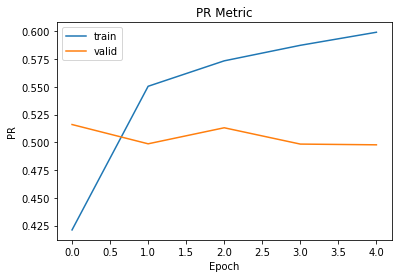

In [ ]:
plt.plot(history.history['pr_metric'])
plt.plot(history.history['val_pr_metric'])
plt.title('PR Metric')
plt.ylabel('PR')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/PRMetric.png')
plt.show()


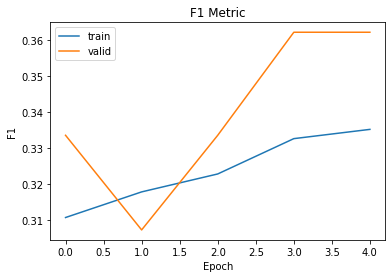

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Metric')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/F1.png')
plt.show()


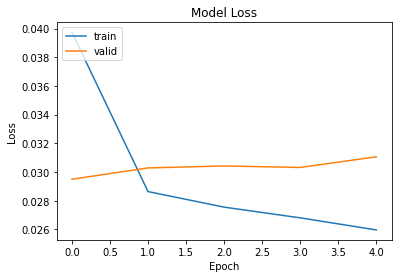

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/Loss.png')
plt.show()


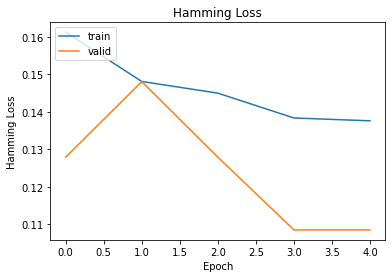

In [ ]:
plt.plot(history.history['hamming_loss'])
plt.plot(history.history['val_hamming_loss'])
plt.title('Hamming Loss')
plt.ylabel('Hamming Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('/content/drive/MyDrive/CS 682/Project/Plots/UNet/HammingLoss.png')
plt.show()
